# Data Science Tech Case

by Guilherme Nascimento

Este arquivo contem a modelagem e os testes usados para as previsões de ofertas por perfil de cliente. Conforme descrito abaixo, foram levadas em consideração as informações de:

* Idade
* Gênero
* Estatísticas de consumo

Variável target: tipo de ofertas (podendo ser mais de uma para cada cliente)

Este arquivo apresenta apenas a modelagem e treinamento dos algoritmos de predição. Para EDA e pre-processamento acesse o arquivo ifood_dataproc.ipynb

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.core.display import display

# Calcular métricas por coluna
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,hamming_loss,jaccard_score
from IPython.core.display import display
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

#OK let's doa k-fold evaluation
from sklearn.model_selection import KFold


def evaluate_multioutput_kfold(model, X, y, n_splits=5, random_state=None):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    metrics_folds = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Treinar e prever
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calcular métricas
        metrics = {
            "Exact Match Ratio": accuracy_score(y_test, y_pred),
            "Hamming Loss": hamming_loss(y_test, y_pred),
            "F1-score (micro)": f1_score(y_test, y_pred, average="micro", zero_division=0),
            "F1-score (macro)": f1_score(y_test, y_pred, average="macro", zero_division=0),
            "Jaccard (samples)": jaccard_score(y_test, y_pred, average="samples", zero_division=0)
        }
        
        metrics_folds.append(metrics)
    
    results = pd.DataFrame(metrics_folds)
    avgs = results.mean().rename("Average")
    stds = results.std().rename("std")
    
    return pd.concat([avgs, stds], axis=1)
    

def plot_auc_roc_and_precision_recall(y_true, y_scores,label=''):

    #y_true = df[label_col]
    #y_scores = df[score_col]

    # ROC
    print(f"Curves from {label}")
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(12,5))

    # Plot ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    # Plot Precision-Recall
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall (AP = {avg_precision:.2f})')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

def evaluate_metrics_each_class(y_test, pred):
    
    class_names = ['offer_usage_bogo','offer_usage_discount','offer_usage_informational']

    resultados = []
    for i, name in enumerate(class_names):
        resultados.append({
            "Classe": name,
            "Accuracy": accuracy_score(y_test.values[:, i], pred[:, i]),
            "Precision": precision_score(y_test.values[:, i], pred[:, i]),
            "Recall": recall_score(y_test.values[:, i], pred[:, i]),
            "F1-score": f1_score(y_test.values[:, i], pred[:, i]),
        })
        plot_auc_roc_and_precision_recall(y_test.values[:, i], pred_scores[i][:,1],name)

    df_resultados = pd.DataFrame(resultados).sort_values(by="Accuracy")
    display(df_resultados)

Lendo os dados gerados no pre-procesamento

In [2]:
df = pd.read_parquet("user_offers_features.parquet")

In [3]:
users_offers_full_final = pd.get_dummies(df.explode("offer_usage"),columns=['offer_usage']).groupby("account_id").max().reset_index()
users_offers_full_final

,account_id,offer_id,offer_type,received,completed,age,gender,registered_on,account_age,amount_sum,amount_count,amount_mean,amount_std,offer_usage_bogo,offer_usage_discount,offer_usage_informational
0,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,informational,1,1,33,M,20170421,8,127.60,8,15.950000,6.572805,1,1,1
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,informational,1,1,40,O,20180109,7,79.46,5,15.892000,6.292688,1,1,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,informational,1,1,59,F,20160304,9,196.86,8,24.607500,6.331932,1,1,1
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,informational,1,1,24,F,20161111,8,154.05,12,12.837500,4.284117,1,1,1
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,informational,1,1,26,F,20170621,8,48.34,18,2.685556,1.922444,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14482,fff3ba4757bd42088c044ca26d73817a,fafdcd668e3743c1bb461111dcafc2a4,informational,1,1,69,F,20150920,9,580.98,11,52.816364,111.327383,1,1,1
14483,fff7576017104bcc8677a8d63322b5e1,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,71,M,20171031,7,29.94,6,4.990000,2.027244,1,1,0
14484,fff8957ea8b240a6b5e634b6ee8eafcf,fafdcd668e3743c1bb461111dcafc2a4,informational,1,0,71,M,20180218,7,12.15,5,2.430000,2.493080,0,0,0
14485,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,informational,1,1,34,M,20170123,8,88.83,12,7.402500,3.008727,1,0,1


Acertando os dados categóricos para adequação dos dados nos algoritoms utilizados

In [4]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, drop=None)
encoded = encoder.fit_transform(users_offers_full_final[["gender"]])
users_offers_full_final[encoder.get_feature_names_out(["gender"])] = encoded
users_offers_full_final

,account_id,offer_id,offer_type,received,completed,age,gender,registered_on,account_age,amount_sum,amount_count,amount_mean,amount_std,offer_usage_bogo,offer_usage_discount,offer_usage_informational,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,informational,1,1,33,M,20170421,8,127.60,8,15.950000,6.572805,1,1,1,0.0,1.0,0.0
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,informational,1,1,40,O,20180109,7,79.46,5,15.892000,6.292688,1,1,1,0.0,0.0,1.0
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,informational,1,1,59,F,20160304,9,196.86,8,24.607500,6.331932,1,1,1,1.0,0.0,0.0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,informational,1,1,24,F,20161111,8,154.05,12,12.837500,4.284117,1,1,1,1.0,0.0,0.0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,informational,1,1,26,F,20170621,8,48.34,18,2.685556,1.922444,0,1,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14482,fff3ba4757bd42088c044ca26d73817a,fafdcd668e3743c1bb461111dcafc2a4,informational,1,1,69,F,20150920,9,580.98,11,52.816364,111.327383,1,1,1,1.0,0.0,0.0
14483,fff7576017104bcc8677a8d63322b5e1,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,71,M,20171031,7,29.94,6,4.990000,2.027244,1,1,0,0.0,1.0,0.0
14484,fff8957ea8b240a6b5e634b6ee8eafcf,fafdcd668e3743c1bb461111dcafc2a4,informational,1,0,71,M,20180218,7,12.15,5,2.430000,2.493080,0,0,0,0.0,1.0,0.0
14485,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,informational,1,1,34,M,20170123,8,88.83,12,7.402500,3.008727,1,0,1,0.0,1.0,0.0


In [5]:
X = users_offers_full_final[['age','gender_F','gender_M','gender_O','account_age','amount_sum','amount_count','amount_mean','amount_std']]
y = users_offers_full_final[['offer_usage_bogo','offer_usage_discount','offer_usage_informational']]
X

,age,gender_F,gender_M,gender_O,account_age,amount_sum,amount_count,amount_mean,amount_std
0,33,0.0,1.0,0.0,8,127.60,8,15.950000,6.572805
1,40,0.0,0.0,1.0,7,79.46,5,15.892000,6.292688
2,59,1.0,0.0,0.0,9,196.86,8,24.607500,6.331932
3,24,1.0,0.0,0.0,8,154.05,12,12.837500,4.284117
4,26,1.0,0.0,0.0,8,48.34,18,2.685556,1.922444
...,...,...,...,...,...,...,...,...,...
14482,69,1.0,0.0,0.0,9,580.98,11,52.816364,111.327383
14483,71,0.0,1.0,0.0,7,29.94,6,4.990000,2.027244
14484,71,0.0,1.0,0.0,7,12.15,5,2.430000,2.493080
14485,34,0.0,1.0,0.0,8,88.83,12,7.402500,3.008727


## Modelos e Testes

Foram realizados 3 algoritmos para os testes (com validação cruzada), associando com metricas para multilabel:
    
* XGboost
* Catboost
* SVM

In [6]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.multioutput import MultiOutputClassifier

#XGboost KFOLD

base_model = XGBClassifier()
multi_model = MultiOutputClassifier(base_model)

evaluate_multioutput_kfold(multi_model, X, y, n_splits=5, random_state=42)

,Average,std
Exact Match Ratio,0.303513,0.005541
Hamming Loss,0.318194,0.002746
F1-score (micro),0.739894,0.001845
F1-score (macro),0.712564,0.002440
Jaccard (samples),0.533467,0.002581


In [7]:
base_model = CatBoostClassifier(verbose=False)
multi_model = MultiOutputClassifier(base_model)

evaluate_multioutput_kfold(multi_model, X, y, n_splits=5, random_state=42)

,Average,std
Exact Match Ratio,0.322357,0.007487
Hamming Loss,0.303031,0.002911
F1-score (micro),0.751438,0.002570
F1-score (macro),0.721845,0.002011
Jaccard (samples),0.533570,0.004910


In [8]:
from sklearn.svm import SVC


base_model =  SVC(kernel='rbf', C=1.0, gamma='scale')
multi_model = MultiOutputClassifier(base_model)

evaluate_multioutput_kfold(multi_model, X, y, n_splits=5, random_state=42)

,Average,std
Exact Match Ratio,0.316077,0.003840
Hamming Loss,0.299395,0.003952
F1-score (micro),0.754900,0.004177
F1-score (macro),0.729447,0.005931
Jaccard (samples),0.514185,0.006161


## Mais resultados

Com o SVM tendo o melhor resultado, vaoms ver outras métricas a fim de entender melhor as categorias de ofertas preditas para cada usuário

Curves from offer_usage_bogo


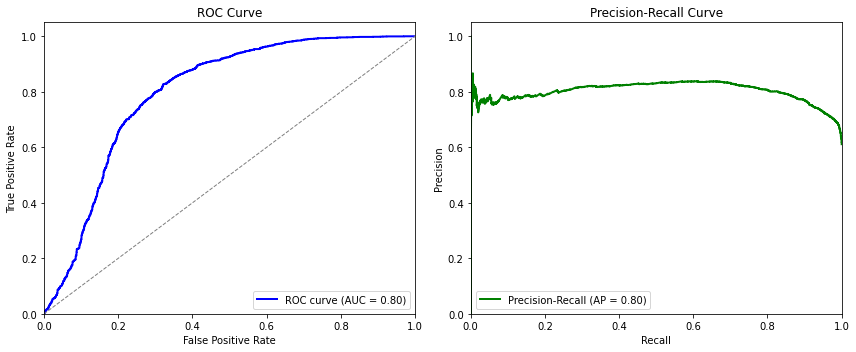

Curves from offer_usage_discount


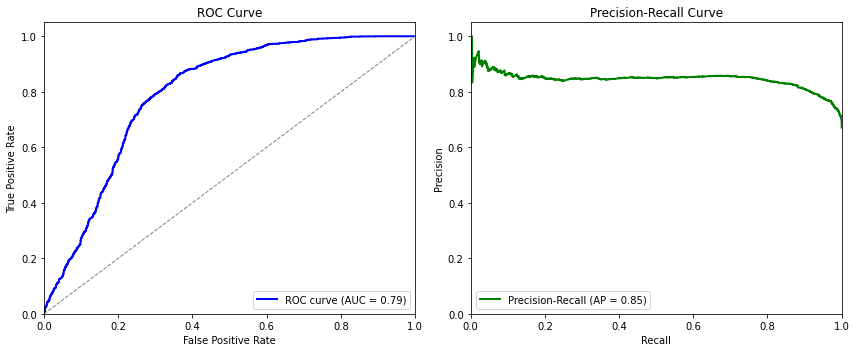

Curves from offer_usage_informational


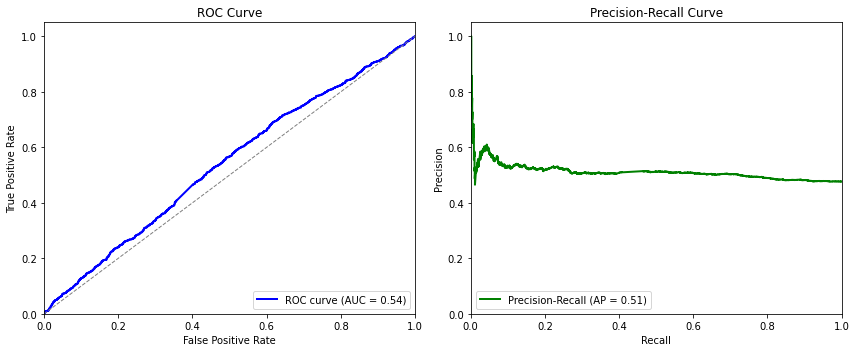

,Classe,Accuracy,Precision,Recall,F1-score
2,offer_usage_informational,0.533407,0.511098,0.493341,0.502062
0,offer_usage_bogo,0.772777,0.784226,0.866757,0.823428
1,offer_usage_discount,0.790447,0.804887,0.907857,0.853277


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

base_model =  SVC(kernel='rbf', C=1.0, gamma='scale',probability=True)
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)

pred = multi_model.predict(X_test)
pred_scores = multi_model.predict_proba(X_test)

evaluate_metrics_each_class(y_test, pred)

## [EXTRA: analisado posteriormente]

Abaixo seguem também como as features impactam nos modelos (usando XGBClassifier para melhor performance). Percebe-se que o maior impacto está relacionado as features de transações (valores e quantidade) nas caregorias BOGO e Discount. Enquanto que Informational apresenta features que não explicam o modelo, mostrando seu comportamento aleatorio

In [12]:
import shap

base_model =  XGBClassifier()
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

Label: offer_usage_bogo


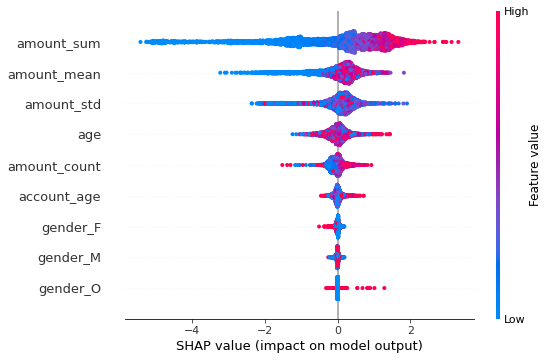

Label: offer_usage_discount


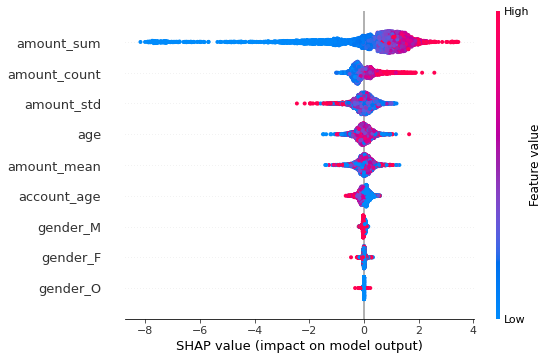

Label: offer_usage_informational


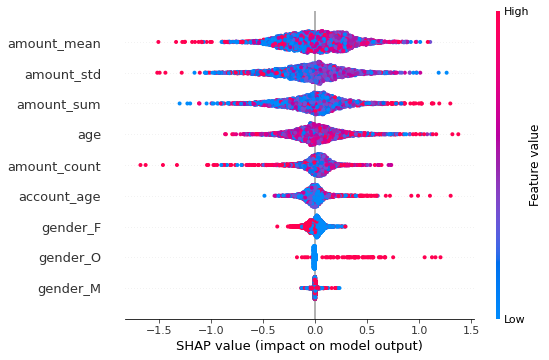

In [15]:
import shap

classes = ['offer_usage_bogo','offer_usage_discount','offer_usage_informational']

for i in range(len(classes)):

    print("Label:",classes[i])
    explainer_out1 = shap.TreeExplainer(multi_model.estimators_[i])
    shap_values_out1 = explainer_out1.shap_values(X_test)
    shap.summary_plot(shap_values_out1, X_test)
    

